# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of two tasks. The first task is to train a model for the following species:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The second task is to finetune the last layer of the trained model to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [1]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob

In [2]:
# We will start by building a dataset class using the following 5 species of fishes
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

# The 5 species will contain 5,000 images in total.
# Let us split the 5,000 images into training (80%) and test (20%) sets
def split_train_test(lendata, percentage=0.8):
    #### ADD YOUR CODE HERE ####
    indices = np.arange(lendata)
    idxs_train = np.random.choice(indices, int(lendata*percentage), replace=False)
    idxs_test = np.setdiff1d(indices, idxs_train)
    
    return idxs_train, idxs_test

LENDATA = 5000
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)

In [3]:
# Implement the dataset class
class FishDataset(Dataset):
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_test,
                 transform_extra=None,
                 img_size=128,
                 train=True):
        # path_to_images: where you put the fish dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # transform_extra: extra data transform
        # img_size: resize all images to a standard size
        # train: return training set or test set

        self.transform = transforms.Compose([
            transform_extra,
            transforms.ToTensor()
        ]) if transform_extra else transforms.ToTensor()
        
        # Load all the images and their labels
        
        all_images = []
        all_labels = []
        for label in Multiclass_labels_correspondances:
            for i in glob.glob(os.path.join(path_to_images,label,'*.png')):
                all_images.append(Image.open(i))
                all_labels.append(Multiclass_labels_correspondances[label])

        print('Number of images:', len(all_images))
        
        # Resize all images to a standard size

        for i in range(len(all_images)):
            all_images[i] = all_images[i].resize((img_size, img_size))
        
        # Extract the images and labels with the specified file indexes      
        
        self.images = [(all_images[i], all_labels[i]) for i in idxs_train] if train else [(all_images[i], all_labels[i]) for i in idxs_test]
        
    def __len__(self):
        # Return the number of samples
        return len(self.images)
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the image and its label
        sample, label = self.images[idx]
        sample = self.transform(sample)
        return sample, label

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

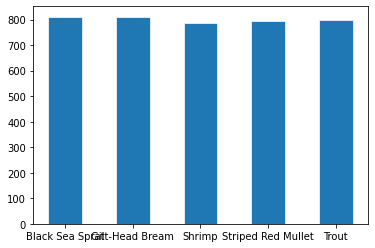

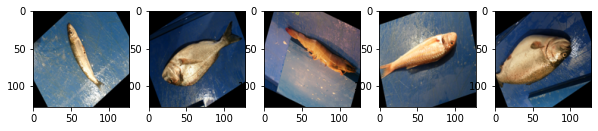

In [19]:
# Training set
img_path = './Fish_Dataset'
dataset  = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)

# Plot the number of samples per class

labels = []
count = []

for label in Multiclass_labels_correspondances:
    labels.append(label)
    count.append(len([i for i in dataset.images if i[1] == Multiclass_labels_correspondances[label]]))

_, ax = plt.subplots()
ax.bar(labels, count, width=0.5, edgecolor="white", linewidth=0.7)
# ax.set(xlim=(0, 5), xticks=np.arange(1, 5))

plt.show()

fig = plt.figure(figsize=(10, 10))

# Plot 1 sample from each of the five classes in the training set

for label in Multiclass_labels_correspondances:
    image = list(filter(lambda x: x[1] == Multiclass_labels_correspondances[label], dataset.images))[0][0]
    fig.add_subplot(1, 5, Multiclass_labels_correspondances[label] + 1)
    plt.imshow(image)

plt.show()


### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?

* Can you think of 3 ways to make the dataset balanced if it is not?

* Is the dataset already pre-processed? If yes, how?

The dataset is fairly balanced, with around 800 training samples per class. If the dataset is not balanced, we have at least three options to choose:

1. Create duplicate samples by rotating, translating, or scaling the images.
2. Reduce the number of samples for classes that have more samples.
3. Record/obtain more samples for classes that have less samples.

The dataset is already pre-processed, and the images are already resized to 128x128 pixels.

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [4]:
class Net(nn.Module):
    def __init__(self, output_dims = 5):
        super(Net, self).__init__()
        # Define the network
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(33*33*32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dims)


    def forward(self, x):
        # Forward propagation
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cpu'

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [5]:
img_path = './Fish_Dataset'

# Network
model = Net().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Number of iterations for training
epochs = 100

# Training batch size
train_batch_size = 32

# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
train_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=train_batch_size, shuffle=False)

Number of images: 5000
Number of images: 5000


### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [6]:
# Network
model = Net().to(device)

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

# Optimiser and learning rate
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Number of iterations for training
epochs = 100

# Training batch size
train_batch_size = 32

for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    
    for imgs, labs in train_dataloader:
        # Get a batch of training data and train the model
        imgs = imgs.to(device)
        labs = labs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labs)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        loss_curve.append(loss.item())

    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

  1%|          | 1/100 [00:35<57:52, 35.08s/it]

--- Iteration 1: training loss = 1.3424 ---


  2%|▏         | 2/100 [01:09<56:58, 34.88s/it]

--- Iteration 2: training loss = 0.2886 ---


  3%|▎         | 3/100 [01:44<56:16, 34.81s/it]

--- Iteration 3: training loss = 0.3394 ---


  4%|▍         | 4/100 [02:19<55:39, 34.79s/it]

--- Iteration 4: training loss = 0.1124 ---


  5%|▌         | 5/100 [02:54<55:02, 34.77s/it]

--- Iteration 5: training loss = 0.1181 ---


  6%|▌         | 6/100 [03:28<54:26, 34.75s/it]

--- Iteration 6: training loss = 0.0798 ---


  7%|▋         | 7/100 [04:03<53:52, 34.76s/it]

--- Iteration 7: training loss = 0.1041 ---


  8%|▊         | 8/100 [04:38<53:24, 34.83s/it]

--- Iteration 8: training loss = 0.1215 ---


  9%|▉         | 9/100 [05:13<52:53, 34.87s/it]

--- Iteration 9: training loss = 0.0463 ---


 10%|█         | 10/100 [05:48<52:17, 34.86s/it]

--- Iteration 10: training loss = 0.0541 ---


 11%|█         | 11/100 [06:22<51:37, 34.80s/it]

--- Iteration 11: training loss = 0.0797 ---


 12%|█▏        | 12/100 [06:57<50:59, 34.77s/it]

--- Iteration 12: training loss = 0.0541 ---


 13%|█▎        | 13/100 [07:32<50:22, 34.75s/it]

--- Iteration 13: training loss = 0.0868 ---


 14%|█▍        | 14/100 [08:07<49:46, 34.73s/it]

--- Iteration 14: training loss = 0.0434 ---


 15%|█▌        | 15/100 [08:41<49:10, 34.72s/it]

--- Iteration 15: training loss = 0.0448 ---


 16%|█▌        | 16/100 [09:16<48:35, 34.71s/it]

--- Iteration 16: training loss = 0.0474 ---


 17%|█▋        | 17/100 [09:51<48:01, 34.71s/it]

--- Iteration 17: training loss = 0.0394 ---


 18%|█▊        | 18/100 [10:25<47:27, 34.72s/it]

--- Iteration 18: training loss = 0.0235 ---


 19%|█▉        | 19/100 [11:00<46:51, 34.71s/it]

--- Iteration 19: training loss = 0.0201 ---


 20%|██        | 20/100 [11:35<46:15, 34.70s/it]

--- Iteration 20: training loss = 0.0529 ---


 21%|██        | 21/100 [12:09<45:40, 34.69s/it]

--- Iteration 21: training loss = 0.0209 ---


 22%|██▏       | 22/100 [12:44<45:06, 34.70s/it]

--- Iteration 22: training loss = 0.0820 ---


 23%|██▎       | 23/100 [13:19<44:31, 34.69s/it]

--- Iteration 23: training loss = 0.1059 ---


 24%|██▍       | 24/100 [13:53<43:55, 34.68s/it]

--- Iteration 24: training loss = 0.0640 ---


 25%|██▌       | 25/100 [14:28<43:20, 34.67s/it]

--- Iteration 25: training loss = 0.0555 ---


 26%|██▌       | 26/100 [15:03<42:47, 34.69s/it]

--- Iteration 26: training loss = 0.0397 ---


 27%|██▋       | 27/100 [15:38<42:11, 34.68s/it]

--- Iteration 27: training loss = 0.0561 ---


 28%|██▊       | 28/100 [16:12<41:36, 34.67s/it]

--- Iteration 28: training loss = 0.0492 ---


 29%|██▉       | 29/100 [16:47<41:00, 34.66s/it]

--- Iteration 29: training loss = 0.0571 ---


 30%|███       | 30/100 [17:21<40:26, 34.66s/it]

--- Iteration 30: training loss = 0.0595 ---


 31%|███       | 31/100 [17:56<39:52, 34.67s/it]

--- Iteration 31: training loss = 0.0256 ---


 32%|███▏      | 32/100 [18:31<39:16, 34.66s/it]

--- Iteration 32: training loss = 0.0293 ---


 33%|███▎      | 33/100 [19:05<38:41, 34.64s/it]

--- Iteration 33: training loss = 0.0126 ---


 34%|███▍      | 34/100 [19:40<38:07, 34.65s/it]

--- Iteration 34: training loss = 0.0098 ---


 35%|███▌      | 35/100 [20:15<37:32, 34.66s/it]

--- Iteration 35: training loss = 0.0005 ---


 36%|███▌      | 36/100 [20:49<36:57, 34.64s/it]

--- Iteration 36: training loss = 0.0191 ---


 37%|███▋      | 37/100 [21:24<36:21, 34.63s/it]

--- Iteration 37: training loss = 0.0115 ---


 38%|███▊      | 38/100 [21:59<35:46, 34.63s/it]

--- Iteration 38: training loss = 0.1276 ---


 39%|███▉      | 39/100 [22:33<35:12, 34.63s/it]

--- Iteration 39: training loss = 0.1117 ---


 40%|████      | 40/100 [23:08<34:37, 34.63s/it]

--- Iteration 40: training loss = 0.0861 ---


 41%|████      | 41/100 [23:42<34:03, 34.64s/it]

--- Iteration 41: training loss = 0.0727 ---


 42%|████▏     | 42/100 [24:17<33:28, 34.64s/it]

--- Iteration 42: training loss = 0.0591 ---


 43%|████▎     | 43/100 [24:52<32:54, 34.63s/it]

--- Iteration 43: training loss = 0.0302 ---


 44%|████▍     | 44/100 [25:26<32:19, 34.64s/it]

--- Iteration 44: training loss = 0.0294 ---


 45%|████▌     | 45/100 [26:01<31:45, 34.64s/it]

--- Iteration 45: training loss = 0.0386 ---


 46%|████▌     | 46/100 [26:36<31:09, 34.63s/it]

--- Iteration 46: training loss = 0.0549 ---


 47%|████▋     | 47/100 [27:10<30:36, 34.65s/it]

--- Iteration 47: training loss = 0.0394 ---


 48%|████▊     | 48/100 [33:41<2:02:37, 141.49s/it]

--- Iteration 48: training loss = 0.0065 ---


 49%|████▉     | 49/100 [34:15<1:32:53, 109.29s/it]

--- Iteration 49: training loss = 0.0103 ---


 50%|█████     | 50/100 [50:10<5:02:31, 363.02s/it]

--- Iteration 50: training loss = 0.0057 ---


 51%|█████     | 51/100 [50:44<3:35:53, 264.35s/it]

--- Iteration 51: training loss = 0.0708 ---


 52%|█████▏    | 52/100 [51:19<2:36:13, 195.28s/it]

--- Iteration 52: training loss = 0.0572 ---


 53%|█████▎    | 53/100 [51:53<1:55:06, 146.95s/it]

--- Iteration 53: training loss = 0.1111 ---


 54%|█████▍    | 54/100 [52:27<1:26:43, 113.13s/it]

--- Iteration 54: training loss = 0.0490 ---


 55%|█████▌    | 55/100 [53:01<1:07:07, 89.49s/it] 

--- Iteration 55: training loss = 0.1147 ---


 56%|█████▌    | 56/100 [53:36<53:30, 72.96s/it]  

--- Iteration 56: training loss = 0.0467 ---


 57%|█████▋    | 57/100 [1:11:07<4:22:33, 366.35s/it]

--- Iteration 57: training loss = 0.0818 ---


 58%|█████▊    | 58/100 [1:11:41<3:06:40, 266.69s/it]

--- Iteration 58: training loss = 0.0270 ---


 59%|█████▉    | 59/100 [1:12:15<2:14:33, 196.92s/it]

--- Iteration 59: training loss = 0.0933 ---


 60%|██████    | 60/100 [1:12:49<1:38:42, 148.07s/it]

--- Iteration 60: training loss = 0.0201 ---


 61%|██████    | 61/100 [1:30:18<4:31:50, 418.23s/it]

--- Iteration 61: training loss = 0.0188 ---


 62%|██████▏   | 62/100 [1:30:52<3:11:54, 303.01s/it]

--- Iteration 62: training loss = 0.0454 ---


 63%|██████▎   | 63/100 [1:31:26<2:17:06, 222.34s/it]

--- Iteration 63: training loss = 0.0137 ---


 64%|██████▍   | 64/100 [1:32:00<1:39:31, 165.87s/it]

--- Iteration 64: training loss = 0.1112 ---


 65%|██████▌   | 65/100 [1:32:34<1:13:42, 126.34s/it]

--- Iteration 65: training loss = 0.0141 ---


 66%|██████▌   | 66/100 [1:33:08<55:55, 98.68s/it]   

--- Iteration 66: training loss = 0.0193 ---


 67%|██████▋   | 67/100 [1:33:42<43:37, 79.32s/it]

--- Iteration 67: training loss = 0.0337 ---


 68%|██████▊   | 68/100 [1:34:17<35:04, 65.77s/it]

--- Iteration 68: training loss = 0.0030 ---


 69%|██████▉   | 69/100 [1:50:35<2:55:27, 339.59s/it]

--- Iteration 69: training loss = 0.0008 ---


 70%|███████   | 70/100 [2:06:27<4:21:40, 523.34s/it]

--- Iteration 70: training loss = 0.0797 ---


 71%|███████   | 71/100 [2:07:01<3:01:59, 376.55s/it]

--- Iteration 71: training loss = 0.0713 ---


 72%|███████▏  | 72/100 [2:23:34<4:22:02, 561.51s/it]

--- Iteration 72: training loss = 0.1168 ---


 73%|███████▎  | 73/100 [2:24:08<3:01:28, 403.28s/it]

--- Iteration 73: training loss = 0.0219 ---


 74%|███████▍  | 74/100 [2:24:42<2:06:45, 292.53s/it]

--- Iteration 74: training loss = 0.1001 ---


 75%|███████▌  | 75/100 [2:25:16<1:29:34, 214.99s/it]

--- Iteration 75: training loss = 0.1336 ---


 76%|███████▌  | 76/100 [2:25:51<1:04:16, 160.70s/it]

--- Iteration 76: training loss = 0.0327 ---


 77%|███████▋  | 77/100 [2:26:25<47:02, 122.71s/it]  

--- Iteration 77: training loss = 0.0496 ---


 78%|███████▊  | 78/100 [2:26:59<35:14, 96.13s/it] 

--- Iteration 78: training loss = 0.0569 ---


 79%|███████▉  | 79/100 [2:27:33<27:07, 77.51s/it]

--- Iteration 79: training loss = 0.0242 ---


 80%|████████  | 80/100 [2:28:07<21:29, 64.50s/it]

--- Iteration 80: training loss = 0.0171 ---


 81%|████████  | 81/100 [2:28:41<17:32, 55.39s/it]

--- Iteration 81: training loss = 0.0000 ---


 82%|████████▏ | 82/100 [2:29:15<14:42, 49.01s/it]

--- Iteration 82: training loss = 0.0793 ---


 83%|████████▎ | 83/100 [2:29:49<12:37, 44.55s/it]

--- Iteration 83: training loss = 0.0162 ---


 84%|████████▍ | 84/100 [2:30:23<11:02, 41.42s/it]

--- Iteration 84: training loss = 0.0126 ---


 85%|████████▌ | 85/100 [2:30:58<09:48, 39.24s/it]

--- Iteration 85: training loss = 0.0928 ---


 86%|████████▌ | 86/100 [2:31:32<08:48, 37.73s/it]

--- Iteration 86: training loss = 0.0304 ---


 87%|████████▋ | 87/100 [2:32:06<07:56, 36.68s/it]

--- Iteration 87: training loss = 0.0133 ---


 88%|████████▊ | 88/100 [2:32:40<07:11, 35.95s/it]

--- Iteration 88: training loss = 0.0516 ---


 89%|████████▉ | 89/100 [2:33:14<06:29, 35.44s/it]

--- Iteration 89: training loss = 0.0282 ---


 90%|█████████ | 90/100 [2:33:49<05:50, 35.10s/it]

--- Iteration 90: training loss = 0.0272 ---


 91%|█████████ | 91/100 [2:34:23<05:13, 34.86s/it]

--- Iteration 91: training loss = 0.0295 ---


 92%|█████████▏| 92/100 [2:34:57<04:37, 34.72s/it]

--- Iteration 92: training loss = 0.0566 ---


 93%|█████████▎| 93/100 [2:35:32<04:02, 34.62s/it]

--- Iteration 93: training loss = 0.0394 ---


 94%|█████████▍| 94/100 [2:36:06<03:27, 34.55s/it]

--- Iteration 94: training loss = 0.0003 ---


 95%|█████████▌| 95/100 [2:36:41<02:52, 34.50s/it]

--- Iteration 95: training loss = 0.0591 ---


 96%|█████████▌| 96/100 [2:37:15<02:18, 34.57s/it]

--- Iteration 96: training loss = 0.0501 ---


 97%|█████████▋| 97/100 [2:37:50<01:43, 34.52s/it]

--- Iteration 97: training loss = 0.0572 ---


 98%|█████████▊| 98/100 [2:38:24<01:08, 34.48s/it]

--- Iteration 98: training loss = 0.0524 ---


 99%|█████████▉| 99/100 [2:38:59<00:34, 34.45s/it]

--- Iteration 99: training loss = 0.0132 ---


100%|██████████| 100/100 [2:39:33<00:00, 95.73s/it]

--- Iteration 100: training loss = 0.0110 ---


### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [4]:
# Deploy the model
model.eval()
ground_truth = []
predictions = []
with torch.no_grad():
    for imgs, labs in test_dataloader:
        imgs = imgs.to(device)
        labs = labs.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        ground_truth.extend(labs.cpu().numpy().tolist())
        predictions.extend(predicted.cpu().numpy().tolist())

NameError: name 'model' is not defined

### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

In [111]:
# Evaluate the performance of the model and visualize the confusion matrix
def confusion_matrix(ground_truth, predictions):
    cm = np.zeros((5, 5))
    for i in range(len(ground_truth)):
        cm[ground_truth[i]][predictions[i]] += 1
    return cm

print('--- Performance of the model on the test set ---')
print(confusion_matrix(ground_truth, predictions))
# Calculate the accuracy, precision, recall, and F1 score of the model
accuracy = np.trace(confusion_matrix(ground_truth, predictions)) / np.sum(confusion_matrix(ground_truth, predictions))
precision = np.zeros((5,))
recall = np.zeros((5,))
f1_score = np.zeros((5,))
for i in range(5):
    precision[i] = confusion_matrix(ground_truth, predictions)[i][i] / np.sum(confusion_matrix(ground_truth, predictions)[i])
    recall[i] = confusion_matrix(ground_truth, predictions)[i][i] / np.sum(confusion_matrix(ground_truth, predictions)[:, i])
    f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

# print accuracy, precision, recall, and F1 score for each class
print('Accuracy: {0:.4f}'.format(accuracy))
# print precision, recall, and F1 score for each class
for i in range(5):
    print('Class {0}: precision = {1:.4f}, recall = {2:.4f}, F1 score = {3:.4f}'.format(i, precision[i], recall[i], f1_score[i]))

--- Performance of the model on the test set ---
[[189.   0.   0.   0.   0.]
 [  0. 188.   0.   2.   1.]
 [  0.   1. 212.   0.   0.]
 [  2.   3.   2. 197.   0.]
 [  0.   2.   0.   0. 201.]]
Accuracy: 0.9870
Class 0: precision = 1.0000, recall = 0.9895, F1 score = 0.9947
Class 1: precision = 0.9843, recall = 0.9691, F1 score = 0.9766
Class 2: precision = 0.9953, recall = 0.9907, F1 score = 0.9930
Class 3: precision = 0.9657, recall = 0.9899, F1 score = 0.9777
Class 4: precision = 0.9901, recall = 0.9950, F1 score = 0.9926


## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only include the new classes and regenerate the datasets and dataloaders.

In [12]:
Multiclass_labels_correspondances ={
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3}

In [13]:
LENDATA = 4000
idxs_train,idxs_test = split_train_test(LENDATA, 0.8)

# Dataloaders
train_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=train_batch_size, shuffle=False)

Number of images: 4000
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

OSError: unrecognized data stream contents when reading image file

### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [112]:
def freeze_till_last(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_till_last(model)
# Modify the last layer. This layer is not freezed.
model.fc3.weight.requires_grad = True
model.fc3.bias.requires_grad = True

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Number of iterations for training
epochs = 100

# Training batch size
train_batch_size = 32

### Step 4.3: Train and test your finetuned model. (5 points)

In [ ]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    for imgs, labs in train_dataloader:
        # Get a batch of training data and train the model
        imgs = imgs.to(device)
        labs = labs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()
        loss_curve.append(loss.item())
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

# Deploy the model on the test set
model.eval()
ground_truth = []
predictions = []
with torch.no_grad():
    for imgs, labs in test_dataloader:
        imgs = imgs.to(device)
        labs = labs.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        ground_truth.extend(labs.cpu().numpy().tolist())
        predictions.extend(predicted.cpu().numpy().tolist())

# Evaluate the performance
print('--- Performance of the model on the test set ---')
print(confusion_matrix(ground_truth, predictions))
# Calculate the accuracy, precision, recall, and F1 score of the model
accuracy = np.trace(confusion_matrix(ground_truth, predictions)) / np.sum(confusion_matrix(ground_truth, predictions))
precision = np.zeros((5,))
recall = np.zeros((5,))
f1_score = np.zeros((5,))
for i in range(5):
    precision[i] = confusion_matrix(ground_truth, predictions)[i][i] / np.sum(confusion_matrix(ground_truth, predictions)[i])
    recall[i] = confusion_matrix(ground_truth, predictions)[i][i] / np.sum(confusion_matrix(ground_truth, predictions)[:, i])
    f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

# print accuracy, precision, recall, and F1 score for each class
print('Accuracy: {0:.4f}'.format(accuracy))

### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

#### ADD YOUR RESPONSE HERE ####